In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных 

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [2]:
batch_size = 16
image_size = 128

dataset = ImageFolder(root=,
                       transform=tt.Compose([tt.Resize(128),
                                             tt.CenterCrop(128),
                                             tt.ToTensor(),
                                             tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)

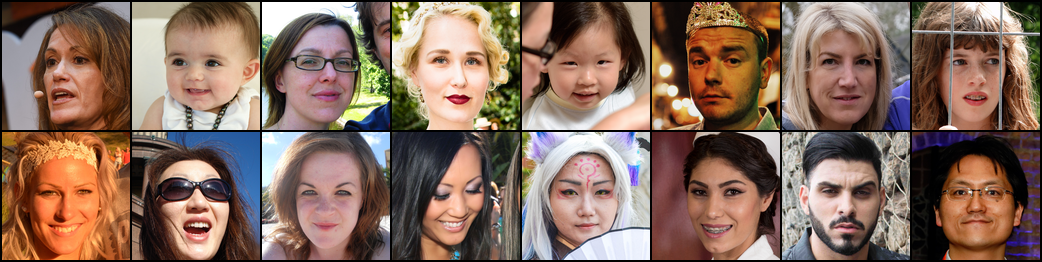

In [3]:
grid = make_grid(next(iter(dataloader))[0], normalize=True)

img = tt.ToPILImage()(grid)
img

## Часть 2. Построение и обучение модели

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# Задание 1 
Соберите и обучите дискриминатор и генератор.

In [5]:
discriminator = nn.Sequential(
    
).to(device)

In [6]:
latent_size = 1024

generator = nn.Sequential(
    
).to(device)

In [ ]:
from torchsummary import summary

summary(discriminator, (3, 128, 128))

In [ ]:
summary(generator, (latent_size, 1, 1))

In [ ]:
img_list = []

fixed_noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
fixed_images = generator(fixed_noise)

grid = make_grid(fixed_images, normalize=True, padding=2)
img_list.append(grid)
plt.figure(figsize=(16, 14))
plt.imshow(tt.ToPILImage()(grid))
plt.grid(False)
plt.axis('off')
plt.show()

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [10]:
model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

# Задание 2
Написать функцию обучения генератора и дискриминатора

In [11]:
from IPython.display import clear_output

def fit(models, criterion, epochs, lr):
    models["discriminator"].train()
    models["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    optimizer = {
        "discriminator": 
        "generator": 
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in dataloader:
            # images to device

            # Discriminator train
            # clear discriminator gradients


            # real images

            # generate fake images

            # pass fake images through discriminator



            # update discriminator weights

            # Generator train
            # clear generator gradients


            # generate images

            # try to fool the discriminator


            # update generator weights



        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Show images and logs
        clear_output(wait=True)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
               epoch+1, epochs, losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        with torch.no_grad():
            fixed_images = generator(fixed_noise)
        
        grid = make_grid(fixed_images, normalize=True, padding=2)
        img_list.append(grid)
        plt.figure(figsize=(16, 14))
        plt.imshow(tt.ToPILImage()(grid))
        plt.grid(False)
        plt.axis('off')
        plt.show()

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
history = fit(model, criterion, 20, 0.0002)

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(history[0], '-')
plt.plot(history[1], '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(history[2], '-')
plt.plot(history[3], '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Discriminator', 'Generator'])
plt.title('Score');

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 64

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
tt.ToPILImage()(make_grid(model["generator"](fixed_latent), normalize=True))

In [ ]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device), padding=5, normalize=True).cpu(),(1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(make_grid(model["generator"](torch.randn(batch_size, latent_size, 1, 1, device=device)), padding=5, normalize=True).cpu(),(1, 2, 0)))

plt.show()

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(16, 14))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.cpu(),(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [76]:
os.makedirs("models", exist_ok=True)

In [77]:
torch.save(model["discriminator"].state_dict(), "models/model_discriminator.pth")
torch.save(model["generator"].state_dict(), "models/model_generator.pth")

Как вам качество получившихся изображений?

In [23]:
os.makedirs("generated/images", exist_ok=True)

In [24]:
len_train_iamges = len(os.listdir("faces_dataset_full/images/"))
i = 1

for image in range(len_train_iamges):
    latent = torch.randn(1, latent_size, 1, 1, device=device)
    fake_image = model["generator"](latent)
    tt.ToPILImage()(make_grid(fake_image, normalize=True, padding=0)).save(f"generated/images/{i}.png")
    i += 1

In [2]:
# количество изображений для оценки
count_of_images = 3000

X = []
y = []

for image in tqdm(os.listdir("faces_dataset_full/images/")[:count_of_images]):
    X.append(plt.imread(os.path.join("faces_dataset_full/images/", image)).astype("float32"))
    y.append(1)

for image in tqdm(os.listdir("generated/images")[:count_of_images]):
    X.append(plt.imread(os.path.join("generated/images/", image)).astype("float32"))
    y.append(0)

X = np.array(X)
y = np.array(y)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [3]:
X = X.reshape(X.shape[0], -1)

# Задание 3 
Leave-one-out-1-NN classifier accuracy

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

# Задание 4
Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Прокомментируйте получившийся результат: